In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils
import train
import experiments

torch.random.manual_seed(2009)

%matplotlib inline

# Running neural structural optimization with torch 🔥 optimizers

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

In [5]:
rendered_frames, losses, displacement_frames = (
    train.train_adam(problem, cnn_kwargs, lr=4e-3, iterations=500)
)

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:70: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:71: UserWarning: __floordiv__ is deprecated, and its behavior will change

Compliance loss = 2661.9377657218647 / Iteration=0
Compliance loss = 395.80327522957793 / Iteration=10
Compliance loss = 282.39377781844394 / Iteration=20
Compliance loss = 250.67108712188872 / Iteration=30
Compliance loss = 235.41001337073857 / Iteration=40
Compliance loss = 227.3020351621625 / Iteration=50
Compliance loss = 221.79678571084975 / Iteration=60
Compliance loss = 218.07464868193267 / Iteration=70
Compliance loss = 215.0252595006677 / Iteration=80
Compliance loss = 212.6362846524506 / Iteration=90
Compliance loss = 210.43893454868828 / Iteration=100
Compliance loss = 208.8452731570434 / Iteration=110
Compliance loss = 207.49308173597825 / Iteration=120
Compliance loss = 205.91151123011156 / Iteration=130
Compliance loss = 204.91663307297415 / Iteration=140
Compliance loss = 203.4817929706191 / Iteration=150
Compliance loss = 202.55777875131832 / Iteration=160
Compliance loss = 201.94492553987396 / Iteration=170
Compliance loss = 201.07325679706423 / Iteration=180
Complianc

In [6]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


## Plot the structure 🌉

After our model is done training we can plot the final structure.

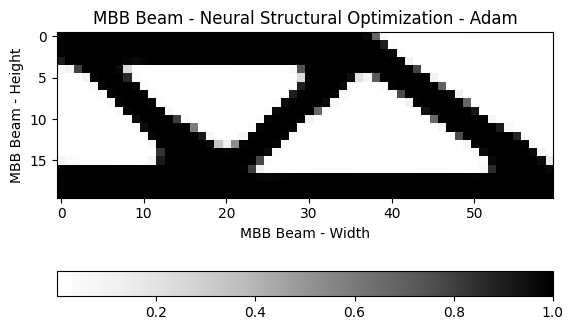

In [7]:
# Get the final frame
final_frame = rendered_frames[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - Adam')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)

# Plot the loss trajectory ☄️

Finally, we will plot the loss directory for **compliance**

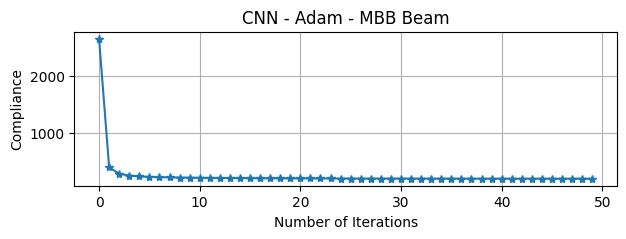

In [8]:
losses = pd.Series(losses)
ax = losses.plot(figsize=(7, 2), marker='*')
ax.set_title('CNN - Adam - MBB Beam')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Compliance')
ax.grid()

# Plot the displacements

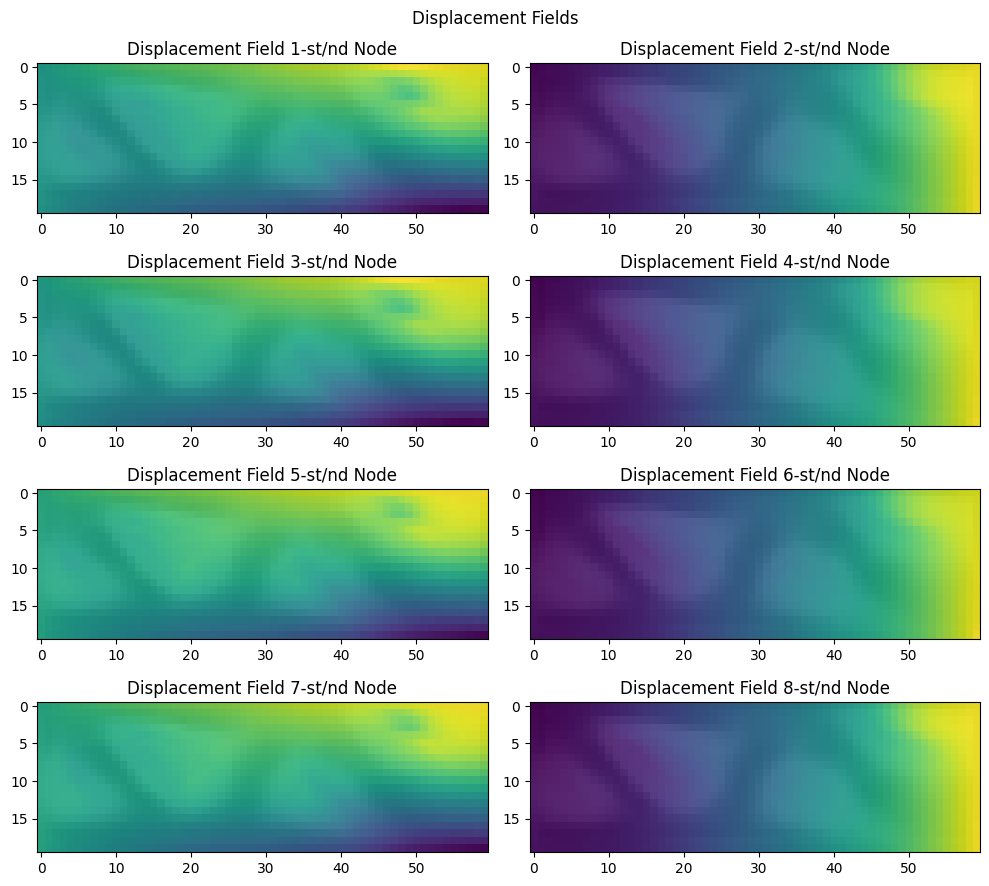

In [15]:
index = 10
final_displacement = displacement_frames[index].detach().numpy()
final_x_phys = rendered_frames[index].detach().numpy()

experiments.plot_displacement(displacement_field=final_displacement, x_phys=final_x_phys)

In [16]:
args = topo_api.specified_task(problem)

x_phys = torch.zeros(args['nely'], args['nelx'])
nodes = utils.build_node_indexes(x_phys)

matlab_u = pd.read_csv('/Users/ryandevera/Desktop/matlab_u_matrix.csv', header=None)

In [17]:
u_matrix = torch.from_numpy(matlab_u.values.flatten())

In [18]:
u_matrix = u_matrix[nodes]

TypeError: Image data of dtype object cannot be converted to float

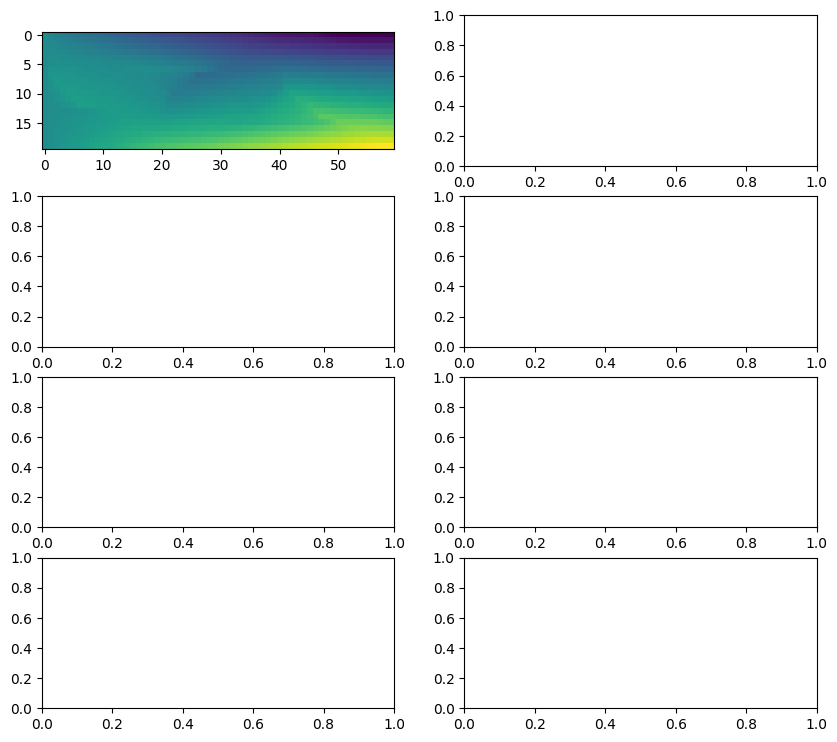

In [19]:
final_displacement = u_matrix
u

# Multi-story Building

The next problem that we will try is multi-story building on a 32 x 64 grid with volume @ 0.5

In [ ]:
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

In [ ]:
rendered_frames, losses = train.train_adam(problem, cnn_kwargs, lr=6e-4)

In [ ]:
# Get the final frame
frames = [25, 50, 100, 300, len(rendered_frames) - 1]

# Create a figure and axis
fig, axes = plt.subplots(1, 5, figsize=(7, 4))
axes = axes.flatten()

for idx, frames in enumerate(frames):
    # Show the structure in grayscale
    im = axes[idx].imshow(rendered_frames[frames].detach().numpy(), cmap='Greys')
    axes[idx].set_ylabel('y')
    axes[idx].set_xlabel('x')
    axes[idx].grid()
    axes[idx].set_title(f'Step={frames}')
    
plt.suptitle('Multi-story Building 32x64 Density 0.5')
fig.tight_layout()

In [ ]:
losses = pd.Series(losses)
ax = losses.plot(figsize=(7, 2), marker='*')
ax.set_title('CNN - Adam - Multi-story Building 32x64 Density 0.5')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Compliance')
ax.grid()

# Let's try the large mbb beam problem

In [ ]:
problem = problems.PROBLEMS_BY_NAME['mbb_beam_192x64_0.4']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

In [ ]:
rendered_frames, losses = train.train_adam(problem, cnn_kwargs, lr=6e-4)

In [ ]:
# Get the final frame
final_frame = rendered_frames[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - 192x64 - Density-0.4')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)

# Larger Multi-story building

In [ ]:
problem = problems.PROBLEMS_BY_NAME['multistory_building_64x128_0.4']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

In [ ]:
rendered_frames, losses = train.train_adam(problem, cnn_kwargs, lr=6e-4)

In [ ]:
# Get the final frame
frames = [25, 50, 100, 300, len(rendered_frames) - 1]

# Create a figure and axis
fig, axes = plt.subplots(1, 5, figsize=(7, 4))
axes = axes.flatten()

for idx, frames in enumerate(frames):
    # Show the structure in grayscale
    im = axes[idx].imshow(rendered_frames[frames].detach().numpy(), cmap='Greys')
    axes[idx].set_ylabel('y')
    axes[idx].set_xlabel('x')
    axes[idx].grid()
    axes[idx].set_title(f'Step={frames}')
    
plt.suptitle('Multi-story Building 64x128 Density 0.4')
fig.tight_layout()

# Thin support bridge

Thin support bridge is currently under construction 🚧

In [ ]:
# we really need more iterations to see the CNN-LBFGS method dominate
problem = problems.PROBLEMS_BY_NAME['thin_support_bridge_128x128_0.2']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

In [ ]:
rendered_frames, losses = train.train_adam(problem, lr=6e-4, iterations=1500)

In [ ]:
# Get the final frame
final_frame = rendered_frames[-1].detach().numpy()
reversed_frame = final_frame[:, ::-1]
bridge_frame = np.hstack([final_frame, reversed_frame] * 2)

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(bridge_frame, cmap='Greys')
ax.set_title('Thin Support Bridge')
ax.set_ylabel('Height')
ax.set_xlabel('Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)